In [1]:
# =============================================================================
# Title: Assignment Week 5 - Sentiment Classification with TF-IDF & Models
# Author: Pankaj Yadav
# Date: 25 Jan 2026
# Description: Build sentiment classification models using stemmed movie reviews
# =============================================================================


#### 1. Load Libraries

In [2]:

# Import libraries
import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

#### 2. Load Data into a dataframe

In [3]:
# STEP 1: Load and Prepare Data with Stemming 

# Load the movie review data
df = pd.read_csv('/Users/pyadav/Documents/DSC550-T303/Assignments/labeledTrainData.tsv', sep='\t')


The above dataframe contains three columns and 25000 rows. The column names are ID, the sentiment score, and the review.There are no null or missing values in any of the columns. There are 96 duplicate reviews but ID's are unique.

#### 3. EDA on data

In [4]:
# Let's do some basic checks on the data and ensure that the data is loaded properly ( check length of dataframe)
print('Length of loaded rows in data frame :',len(df))
print()

# Check for null values
print("Let's check if any rows are missing:\n", df.isnull().sum())  
print()

# Check for duplicate id's
print('There are {} duplicate IDs in the data frame.'.format(df['id'].duplicated().sum()))  
print()

# Check for duplicate reviews
print("Duplicate reviews:", df['review'].duplicated().sum())  
print()

# Print 4 sample duplicate reviews
print(df[df['review'].duplicated(keep=False)].sort_values('review').head(2))

# Check for empty or whitespace-only reviews
print("Empty/whitespace-only reviews:", df['review'].str.strip().eq('').sum())

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")

# Display sentiment distribution and a sample review
print(f"\nSentiment distribution:\n{df['sentiment'].value_counts()}")

# Remove HTML tags
df['review'] = df['review'].str.replace(r'<.*?>', ' ', regex=True)

Length of loaded rows in data frame : 25000

Let's check if any rows are missing:
 id           0
sentiment    0
review       0
dtype: int64

There are 0 duplicate IDs in the data frame.

Duplicate reviews: 96

           id  sentiment                                             review
14734  4102_4          0  'Dead Letter Office' is a low-budget film abou...
5519    985_4          0  'Dead Letter Office' is a low-budget film abou...
Empty/whitespace-only reviews: 0

Dataset shape: (25000, 3)

Sentiment distribution:
sentiment
1    12500
0    12500
Name: count, dtype: int64


The output above shows that the Sentiment distribution of 12500 positive and 12500 negative reviews which means the dataset is perfectly balanced ( 50 - 50 split). 

#### 4. Preparing data for model

##### Get the stemmed data using the same process you did in Week 3.

In [5]:
# Convert all text to lowercase letters

df['review'] = df['review'].str.lower()

In [6]:
# Remove punctuation and special characters using unicode data library.
punctuation = dict.fromkeys(
  (i for i in range(sys.maxunicode)
  if unicodedata.category(chr(i)).startswith('P')
  ),
  None
)

#  Remove any punctuation characters
df['review'] = df['review'].apply(lambda x: x.translate(punctuation))

# Strip whitespaces and reduce multiple spaces to a single space
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True)

# Remove numbers
df['review'] = df['review'].str.replace(r'\d+', '', regex=True)

# Check a few cleaned samples to ensure they look correct
print(df['review'].head(2))

0    with all this stuff going down at the moment w...
1    the classic war of the worlds by timothy hines...
Name: review, dtype: object


In [7]:
# tokenize the reviews 

df['tokenized_review'] = df['review'].apply(word_tokenize)

print('tokenized reviews:\n', df['tokenized_review'].head(2))

tokenized reviews:
 0    [with, all, this, stuff, going, down, at, the,...
1    [the, classic, war, of, the, worlds, by, timot...
Name: tokenized_review, dtype: object


In [8]:
# Stop words removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

df['tokenized_review'] = df['tokenized_review'].apply(remove_stopwords)

print(f"Sample tokenized review (first 10 tokens): {df['tokenized_review'].iloc[0][:10]}")


Sample tokenized review (first 10 tokens): ['stuff', 'going', 'moment', 'mj', 'ive', 'started', 'listening', 'music', 'watching', 'odd']



Stop Word Removal eliminates common words like 'the', 'is', 'and', and 'a' that appear in virtually every review regardless of sentiment. These words carry little discriminative power for sentiment classification. By removing them, we reduce the vocabulary size  and training time, and allow to focus on import words like 'excellent', 'terrible', 'disappointing', and 'beautiful' that have more sentimental values.

In [9]:
# Apply NLTK’s PorterStemmer.

ps = PorterStemmer()
df['stemmed_review'] = df['tokenized_review'].apply(lambda tokens: [ps.stem(word) for word in tokens])
print(f"Sample stemmed review (first 10 tokens): {df['stemmed_review'].iloc[0][:10]}")


Sample stemmed review (first 10 tokens): ['stuff', 'go', 'moment', 'mj', 'ive', 'start', 'listen', 'music', 'watch', 'odd']



Stemming reduces words to their root form using the Porter Stemmer algorithm. This groups related words that convey similar meanings, e.g. 'running', 'runs' and 'run' all reduce to "run"; 'beautifully', 'beautiful' and 'beauty' all reduce to a common stem. 

Together stop word removal and stemming steps reduce the raw English vocabulary of millions of words to a manageable set of meaningful features. This enables models to train faster, use less memory, and generalize better to new reviews.

In [10]:

# Join the stemmed tokens back into strings for CountVectorizer

df['stemmed_review_str'] = df['stemmed_review'].apply(lambda tokens: ' '.join(tokens))
print('Sample stemmed review string (first 10 words):\n', ' '.join(df['stemmed_review_str'].iloc[0].split()[:10]))

Sample stemmed review string (first 50 words):
 stuff go moment mj ive start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also


##### Split this into a training and test set.

In [11]:
# Train Test  Split


X = df['stemmed_review_str']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set sentiment distribution:\n{y_train.value_counts()}")
print(f"\nTest set sentiment distribution:\n{y_test.value_counts()}")

Training set size: 20000
Test set size: 5000

Training set sentiment distribution:
sentiment
0    10019
1     9981
Name: count, dtype: int64

Test set sentiment distribution:
sentiment
1    2519
0    2481
Name: count, dtype: int64


##### Fit and apply the tf-idf vectorization to the training set.

In [12]:
# FIT and TRANSFORM on training data

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f"Training TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features created: {len(tfidf_vectorizer.get_feature_names_out())}")


Training TF-IDF matrix shape: (20000, 70287)
Number of features created: 70287


##### Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [13]:
# Only TRANSFORM test data but do NOT fit 
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Test TF-IDF matrix shape: {X_test_tfidf.shape}")

Test TF-IDF matrix shape: (5000, 70287)


We fit TF‑IDF on the training set to learn the vocabulary and IDF weights, then we only transform the test set so we don’t leak test information into the model. 

#### 5. Using the data in Models

##### Train a logistic regression using the training data

Logistic Regression for Classification:
- Linear model that outputs probability of each class
- Fast and interpretable
- Works well with TF-IDF features
- Good baseline for text classification

In [14]:
# MODEL 1: LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
# Predictions on test set
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

In [16]:
# Logistic Regression Results : Accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Correctly classified {int(lr_accuracy * len(y_test))} out of {len(y_test)} test samples")

Accuracy: 0.8880
Correctly classified 4440 out of 5000 test samples


In [17]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)


Confusion Matrix:
[[2166  315]
 [ 245 2274]]


Below is the interpretation of above metrix:
- True Negatives  : 2166 negative reviews were correctly predicted as negative.
- False Positives : 315 negative reviews were incorrectly predicted as positive (type I errors).
- False Negatives : 245 positive reviews were incorrectly predicted as negative (missed positives, type II errors).
- True Positives : 2274 positive reviews were correctly predicted as positive.

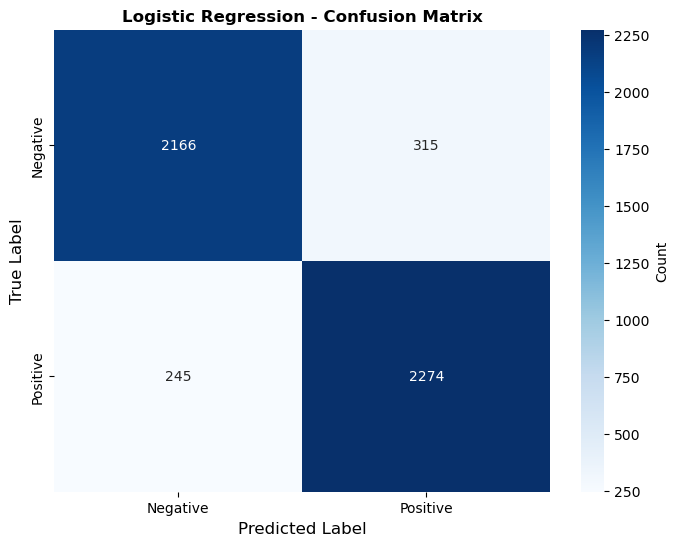

In [18]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Logistic Regression - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.show()


##### Find the model accuracy on test set.

In [19]:
# Precision, Recall, F1-Score
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
print(f"\nPrecision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")


Precision: 0.8783
Recall: 0.9027
F1-Score: 0.8904


Precision score of 0.87 means that out of total predicted positives, the model was able to predict 87.8% correctly. On the other hand the Recall of 90.3% means, that out of all truly positive reviews in the test set, the model correctly identified about 90.3% of them as positive. In other words, it missed roughly 9.7% of the actual positives. An F1 score of 89% means the model has a strong balance between precision and recall—both are high, with neither dominating.

In [20]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

print(f"ROC AUC Score: {roc_auc_lr:.4f}")

ROC AUC Score: 0.9554


ROC curve ranges from 0 to 1. A score of 0.5 means a random guessing while a score of 1 is a perfect classification. Our score is 0.96 ~1.0. Same could be seen in below plot.

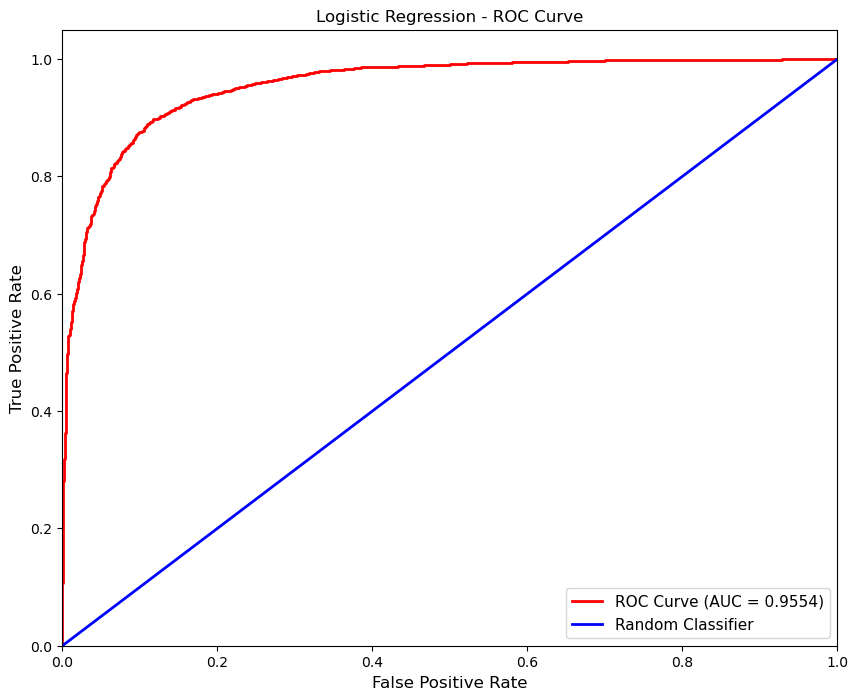

In [21]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='-', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Logistic Regression - ROC Curve')
plt.legend(loc="lower right", fontsize=11)
plt.show()

##### Pick another classification model you learned about this week and repeat steps (5) – (9).

Support Vector Machine (SVM) is another powerful classification algorithm that works by finding the best boundary line or hyperplane that separates positive and negative reviews with maximum distance between them. We use RBF kernel which allows the model to capture non-linear patterns in the data. SVM works very well with high-dimensional text data like our TF-IDF features and can efficiently handle sparse matrices where most values are zero.

In [22]:
# MODEL 2: SUPPORT VECTOR MACHINE (SVM) with RBF Kernel

svm_model = SVC(kernel='rbf', probability=True, random_state=42, max_iter=1000)
svm_model.fit(X_train_tfidf, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:
# Predictions on test set
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]

In [24]:
# Accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Correctly classified {int(svm_accuracy * len(y_test))} out of {len(y_test)} test samples")


Accuracy: 0.8118
Correctly classified 4059 out of 5000 test samples


In [25]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm_svm)

Confusion Matrix:
[[2061  420]
 [ 521 1998]]


Below is the interpretation of above confusion matrix:
- True Negatives  : 2061 negative reviews were correctly predicted as negative.
- False Positives : 420 negative reviews were incorrectly predicted as positive (type I errors).
- False Negatives : 521 positive reviews were incorrectly predicted as negative (missed positives, type II errors).
- True Positives  : 1998 positive reviews were correctly predicted as positive.

Comparison between SVN & Logistic Regression:

- Total number of FP & FN in Logistic regression confusion matrix were 560 total errors
- Total number of FP & FN in SVN confusion matrix are 941 total errors.
- Also, Logistic Regression correctly identified both True Negetives (2166) and True Positives (2277) higher than SVN ( TN 2061 and TP are 1998)

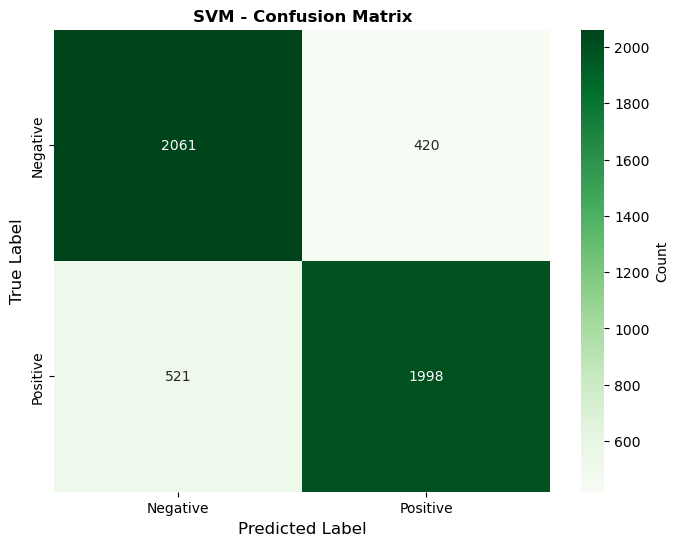

In [26]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('SVM - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.show()

In [27]:
# Precision, Recall, F1-Score
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-Score: {svm_f1:.4f}")

Precision: 0.8263
Recall: 0.7932
F1-Score: 0.8094


Logistic Regression vs SVM based on all three scores:

- Precision: Logistic Regression (87.8%) > SVM (82.6%) - 5.2% higher
- Recall: Logistic Regression (90.2%) > SVM (79.3%) - ~ 10% higher
- F1-Score: Logistic Regression (89.0%) > SVM (80.9%) - ~10% higher

Logistic Regression consistently outperforms SVM across all metrics, indicating it's the better model for this sentiment classification task.

In [28]:
# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f"ROC AUC Score: {roc_auc_svm:.4f}")

ROC AUC Score: 0.8948


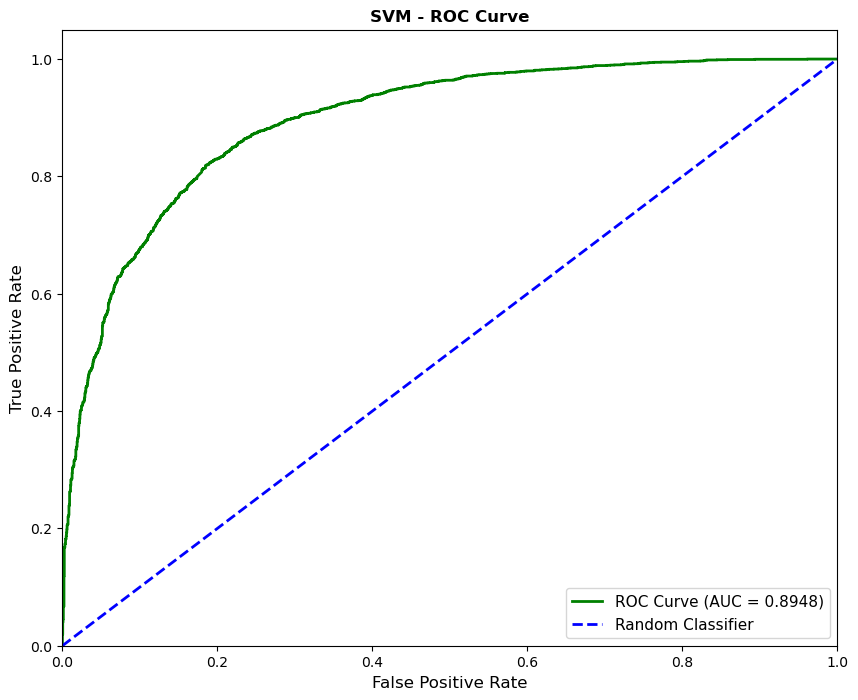

In [29]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'ROC Curve (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('SVM - ROC Curve', fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.show()

#### Conclusion

We built two models, Logistic Regression and Support Vector Machine (SVM) on movie review data using TF-IDF features.

Logistic Regression clearly emerged as the better model with superior performance across all evaluation metrics:

- Accuracy: 88.8% - correctly classified 4,440 out of 5,000 test samples
- Precision: 87.8% - when it predicted positive, it was right 87.85% of the time
- Recall: 90.2% - captured 90.39% of all actual positive reviews
- F1-Score: 89.0% - excellent balance between precision and recall
- ROC AUC: 0.96 - near-perfect ability to distinguish between classes

In comparison, the SVM model with RBF kernel showed lower performance:
- Accuracy: 81.1%, Precision: 82.6%, Recall: 79.3%, F1-Score: 80.9%
- Total errors: 941 vs only 560 errors in Logistic Regression

##### Final Recommendation:

Logistic Regression is the recommended model for this sentiment classification task due to its superior accuracy, better recall in catching positive reviews, and computational efficiency. It achieved nearly perfect ROC of ~1.0 while being faster to train and easier to interpret than SVM. 

Additionally, I used just 1000 iterations of SVM and the accuracy could be marginally increased with higher number of iterations, but still, comparatively the Logistic Regression will still be efficient.